# Loading the libraries

In [2]:
import math
import os
import gc
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
### Parameters for our model
INPUT_COLUMN = 'code'
TARGET_COLUMN = 'text'
NUM_SAMPLES = 100000 #40000
MAX_VOCAB_SIZE = 2**14

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 3  # Number of epochs to train for.
MAX_LENGTH = 15

In [5]:


# Global parameters
root_folder='/content/drive'
data_folder_name='My Drive/datasets/ara_eng_translations'
checkpoint_folder = "My Drive/Projects/Transformer_NMT/ckpt/"
df = pd.read_csv("/kaggle/input/code2text/combined_columns_filtered.tsv",
    sep="\t", 
    header=None,
    names=[TARGET_COLUMN,INPUT_COLUMN]
)

checkpoint_path = os.path.abspath(os.path.join(root_folder, checkpoint_folder))




In [6]:
df = df.iloc[:NUM_SAMPLES]

In [7]:
input_data = df[INPUT_COLUMN].tolist()  
target_data = df[TARGET_COLUMN].tolist() 

In [8]:
# Print sample sentences
print('Number of sentences:', len(input_data))
print(input_data[:5])  # Sample English sentences
print(target_data[:5])  # Sample Arabic translations

Number of sentences: 99393
['code', 'int c, small, big, a, l;', 'cin >> c >> small >> big >> a >> l;', 'int cnt = 0;', 'int p = 0;']
['text', 'declare integers c, small, big, a, l', 'read c, small, big, a, l', 'set cnt to 0', 'set p to 0']


In [9]:
#Delete the dataframe and release the memory (if it is possible)
del df
gc.collect()

0

In [10]:
def subword_tokenize(corpus, vocab_size, max_length):
  # Create the vocabulary using Subword tokenization
  tokenizer_corpus = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    corpus, target_vocab_size=vocab_size)
  # Get the final vocab size, adding the eos and sos tokens
  num_words = tokenizer_corpus.vocab_size + 2
  # Set eos and sos token
  sos_token = [num_words-2]
  eos_token = [num_words-1]
  # Tokenize the corpus
  sentences = [sos_token + tokenizer_corpus.encode(sentence) + eos_token
          for sentence in corpus]
  # Identify the index of the sentences longer than max length
  idx_to_remove = [count for count, sent in enumerate(sentences)
                 if len(sent) > max_length]
  #Pad the sentences
  sentences = tf.keras.preprocessing.sequence.pad_sequences(sentences,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=max_length)
  
  return sentences, tokenizer_corpus, num_words, sos_token, eos_token, idx_to_remove


In [11]:
# Tokenize and pad the input sequences
encoder_inputs, tokenizer_inputs, num_words_inputs, sos_token_input, eos_token_input, del_idx_inputs= subword_tokenize(input_data, 
                                                                                                        MAX_VOCAB_SIZE, MAX_LENGTH)
# Tokenize and pad the outputs sequences
decoder_outputs, tokenizer_outputs, num_words_output, sos_token_output, eos_token_output, del_idx_outputs = subword_tokenize(target_data, 
                                                                                                        MAX_VOCAB_SIZE, MAX_LENGTH)

In [12]:
# Check the tokenize function
print(encoder_inputs[:5], sos_token_input, eos_token_input)
print(decoder_outputs[:5], sos_token_output, eos_token_output)

[[5931 3173 5932    0    0    0    0    0    0    0    0    0    0    0
     0]
 [5931    3 5774    4 2875    4 1884    4 5772    4 5783 5734 5932    0
     0]
 [5931   12    6 5774    6 2875    6 1884    6 5772    6 5783 5734 5932
     0]
 [5931    3   50    1 5723 5734 5932    0    0    0    0    0    0    0
     0]
 [5931    3 5787    1 5723 5734 5932    0    0    0    0    0    0    0
     0]] [5931] [5932]
[[9325 1459 9326    0    0    0    0    0    0    0    0    0    0    0
     0]
 [9325   31   46 9168    2 4123    2 2275    2 9166    2 9177 9326    0
     0]
 [9325    9 9168    2 4123    2 2275    2 9166    2 9177 9326    0    0
     0]
 [9325    8  161    1 9117 9326    0    0    0    0    0    0    0    0
     0]
 [9325    8  134    1 9117 9326    0    0    0    0    0    0    0    0
     0]] [9325] [9326]


In [13]:
print('Size of Input Vocabulary: ', num_words_inputs)
print('Size of Output Vocabulary: ', num_words_output)

Size of Input Vocabulary:  5933
Size of Output Vocabulary:  9327


In [14]:
# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_outputs))
dataset = dataset.shuffle(len(input_data), reshuffle_each_iteration=True).batch(
    BATCH_SIZE, drop_remainder=True)

dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
def scaled_dot_product_attention(queries, keys, values, mask):
    # Calculate the dot product, QK_transpose
    product = tf.matmul(queries, keys, transpose_b=True)
    # Get the scale factor
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    # Apply the scale factor to the dot product
    scaled_product = product / tf.math.sqrt(keys_dim)
    # Apply masking when it is requiered
    if mask is not None:
        scaled_product += (mask * -1e9)
    # dot product with Values
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)
    
    return attention

In [16]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.n_heads == 0
        # Calculate the dimension of every head or projection
        self.d_head = self.d_model // self.n_heads
        # Set the weight matrices for Q, K and V
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        # Set the weight matrix for the output of the multi-head attention W0
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        # Set the dimension of the projections
        shape = (batch_size,
                 -1,
                 self.n_heads,
                 self.d_head)
        # Split the input vectors
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask):
        # Get the batch size
        batch_size = tf.shape(queries)[0]
        # Set the Query, Key and Value matrices
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        # Split Q, K y V between the heads or projections
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        # Apply the scaled dot product
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        # Get the attention scores
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        # Concat the h heads or projections
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))
        # Apply W0 to get the output of the multi-head attention
        outputs = self.final_lin(concat_attention)
        
        return outputs

$PE_{(pos,2i)} =\sin(pos/10000^{2i/dmodel})$

$PE_{(pos,2i+1)} =\cos(pos/10000^{2i/dmodel})$

In [17]:
class PositionalEncoding(layers.Layer):

    def __init__(self):
        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model): # pos: (seq_length, 1) i: (1, d_model)
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles # (seq_length, d_model)

    def call(self, inputs):
        # input shape batch_size, seq_length, d_model
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        # Calculate the angles given the input
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        # Calculate the positional encodings
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        # Expand the encodings with a new dimension
        pos_encoding = angles[np.newaxis, ...]
        
        return inputs + tf.cast(pos_encoding, tf.float32)

In [18]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(EncoderLayer, self).__init__()
        # Hidden units of the feed forward component
        self.FFN_units = FFN_units
        # Set the number of projectios or heads
        self.n_heads = n_heads
        # Dropout rate
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        # Build the multihead layer
        self.multi_head_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        # Layer Normalization
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        # Fully connected feed forward layer
        self.ffn1_relu = layers.Dense(units=self.FFN_units, activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        # Layer normalization
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training):
        # Forward pass of the multi-head attention
        attention = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        attention = self.dropout_1(attention, training=training)
        # Call to the residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call to the FC layer
        outputs = self.ffn1_relu(attention)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        # Call to residual connection and the layer normalization
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [19]:
class Encoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, mask, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training=training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training=training)

        return outputs

In [20]:
class DecoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        
        # Self multi head attention, causal attention
        self.multi_head_causal_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        # Multi head attention, encoder-decoder attention 
        self.multi_head_enc_dec_attention = MultiHeadAttention(self.n_heads)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Feed foward
        self.ffn1_relu = layers.Dense(units=self.FFN_units,
                                    activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Call the masked causal attention
        attention = self.multi_head_causal_attention(inputs,
                                                inputs,
                                                inputs,
                                                mask_1)
        attention = self.dropout_1(attention, training=training)
        # Residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call the encoder-decoder attention
        attention_2 = self.multi_head_enc_dec_attention(attention,
                                                  enc_outputs,
                                                  enc_outputs,
                                                  mask_2)
        attention_2 = self.dropout_2(attention_2, training=training)
        # Residual connection and layer normalization
        attention_2 = self.norm_2(attention_2 + attention)
        # Call the Feed forward
        outputs = self.ffn1_relu(attention_2)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_3(outputs, training=training)
        # Residual connection and layer normalization
        outputs = self.norm_3(outputs + attention_2)
        
        return outputs

In [21]:
class Decoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="decoder"):
        super(Decoder, self).__init__(name=name)
        self.d_model = d_model
        self.n_layers = n_layers
        # Embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stacked layers of multi-head attention and feed forward
        self.dec_layers = [DecoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training=training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.dec_layers[i](outputs,
                                         enc_outputs,
                                         mask_1,
                                         mask_2,
                                         training=training)

        return outputs

In [22]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 vocab_size_enc,
                 vocab_size_dec,
                 d_model,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        # Build the encoder
        self.encoder = Encoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_enc,
                               d_model)
        # Build the decoder
        self.decoder = Decoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_dec,
                               d_model)
        # build the linear transformation and softmax function
        self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def create_padding_mask(self, seq): #seq: (batch_size, seq_length)
        # Create the mask for padding
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
        # Create the mask for the causal attention
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, dec_inputs, training):
        # Create the padding mask for the encoder
        enc_mask = self.create_padding_mask(enc_inputs)
        # Create the mask for the causal attention
        dec_mask_1 = tf.maximum(
            self.create_padding_mask(dec_inputs),
            self.create_look_ahead_mask(dec_inputs)
        )
        # Create the mask for the encoder-decoder attention
        dec_mask_2 = self.create_padding_mask(enc_inputs)
        # Call the encoder
        enc_outputs = self.encoder(enc_inputs, enc_mask, training=training)
        # Call the decoder
        dec_outputs = self.decoder(dec_inputs,
                                   enc_outputs,
                                   dec_mask_1,
                                   dec_mask_2,
                                   training=training)
        # Call the Linear and Softmax functions
        outputs = self.last_linear(dec_outputs)
        
        return outputs

In [23]:
def loss_function(target, pred):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float to avoid type issues.
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [24]:
from tqdm import tqdm  # Import tqdm for progress bar

def main_train(dataset, transformer, n_epochs, print_every=50):
    ''' Train the transformer model for n_epochs using the data generator dataset'''
    losses = []
    accuracies = []

    for epoch in range(n_epochs):
        print(f"Starting epoch {epoch+1}")
        start = time.time()

        # Reset the loss and accuracy calculations
        train_loss.reset_state()
        train_accuracy.reset_state()

        # Create a tqdm progress bar for the batch loop
        progress_bar = tqdm(enumerate(dataset), total=len(dataset), desc=f"Epoch {epoch+1}", position=0, leave=True)

        for batch, (enc_inputs, targets) in progress_bar:
            # Set the decoder inputs
            dec_inputs = targets[:, :-1]
            # Set the target outputs, right-shifted
            dec_outputs_real = targets[:, 1:]

            with tf.GradientTape() as tape:
                # Call the transformer and get the predicted output
                predictions = transformer(enc_inputs, dec_inputs, training=True)
                # Calculate the loss
                loss = loss_function(dec_outputs_real, predictions)

            # Update the weights and optimizer
            gradients = tape.gradient(loss, transformer.trainable_variables)
            optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

            # Save and store the metrics
            train_loss(loss)
            train_accuracy(dec_outputs_real, predictions)

            # Update tqdm progress bar description with live loss & accuracy
            progress_bar.set_postfix(loss=train_loss.result().numpy(), accuracy=train_accuracy.result().numpy())

            # Print every `print_every` batches
            if batch % print_every == 0:
                losses.append(train_loss.result().numpy())
                accuracies.append(train_accuracy.result().numpy())

        # Save checkpoint after each epoch
        ckpt_save_path = ckpt_manager.save()
        print(f"Saving checkpoint for epoch {epoch+1} in {ckpt_save_path}")
        print(f"Time for 1 epoch: {time.time() - start:.2f} secs\n")

    return losses, accuracies

In [25]:
# Set hyperparamters for the model
D_MODEL = 512 # 512
N_LAYERS = 4 # 6
FFN_UNITS = 512 # 2048
N_HEADS = 8 # 8
DROPOUT_RATE = 0.1 # 0.1


In [26]:
# Clean the session
tf.keras.backend.clear_session()
# Create the Transformer model
transformer = Transformer(vocab_size_enc=num_words_inputs,
                          vocab_size_dec=num_words_output,
                          d_model=D_MODEL,
                          n_layers=N_LAYERS,
                          FFN_units=FFN_UNITS,
                          n_heads=N_HEADS,
                          dropout_rate=DROPOUT_RATE)

# Define a categorical cross entropy loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction="none")
# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(D_MODEL)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)
        

In [27]:
#Create the Checkpoint 
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Last checkpoint restored.")

In [28]:
# Train the model
losses, accuracies = main_train(dataset, transformer, EPOCHS, 100)

Starting epoch 1


Epoch 1: 100%|██████████| 1553/1553 [28:58<00:00,  1.12s/it, accuracy=0.253, loss=1.96] 


Saving checkpoint for epoch 1 in /content/drive/My Drive/Projects/Transformer_NMT/ckpt/ckpt-1
Time for 1 epoch: 1739.23 secs

Starting epoch 2


Epoch 2: 100%|██████████| 1553/1553 [28:39<00:00,  1.11s/it, accuracy=0.389, loss=0.809]


Saving checkpoint for epoch 2 in /content/drive/My Drive/Projects/Transformer_NMT/ckpt/ckpt-2
Time for 1 epoch: 1720.16 secs

Starting epoch 3


Epoch 3: 100%|██████████| 1553/1553 [28:30<00:00,  1.10s/it, accuracy=0.401, loss=0.713]


Saving checkpoint for epoch 3 in /content/drive/My Drive/Projects/Transformer_NMT/ckpt/ckpt-3
Time for 1 epoch: 1711.72 secs



In [31]:
# Save tokenizers using their native method
tokenizer_inputs.save_to_file('tokenizer_inputs.subword')
tokenizer_outputs.save_to_file('tokenizer_outputs.subword')

In [42]:
transformer.save_weights("code_to_text_transformer_weights.weights.h5")

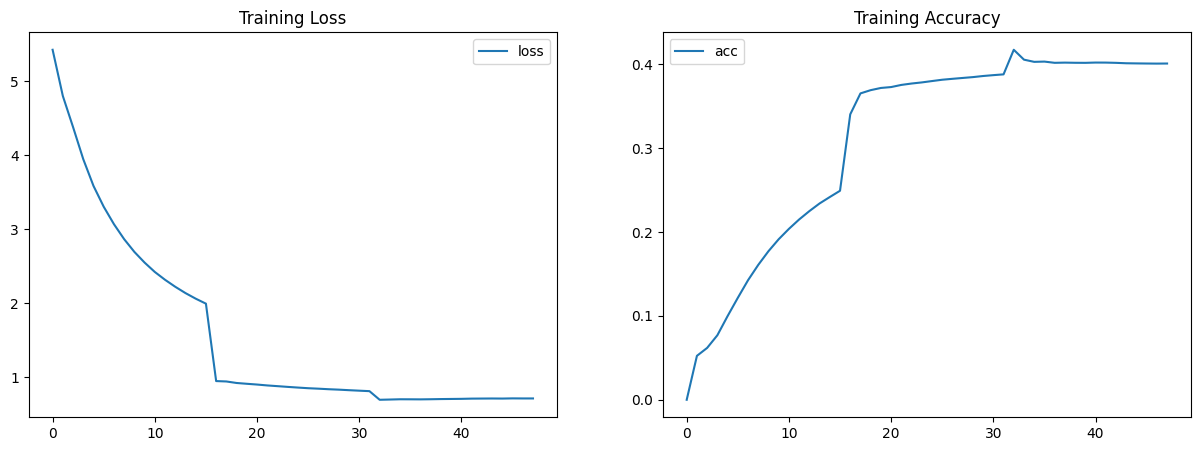

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [34]:
def predict(inp_sentence, tokenizer_in, tokenizer_out, target_max_len):
    # Tokenize the input sequence using the tokenizer_in
    inp_sentence = sos_token_input + tokenizer_in.encode(inp_sentence) + eos_token_input
    enc_input = tf.expand_dims(inp_sentence, axis=0)

    # Set the initial output sentence to sos
    out_sentence = sos_token_output
    # Reshape the output
    output = tf.expand_dims(out_sentence, axis=0)

    # For max target len tokens
    for _ in range(target_max_len):
        # Call the transformer and get the logits 
        predictions = transformer(enc_input, output, training=False) #(1, seq_length, VOCAB_SIZE_ES)
        # Extract the logists of the next word
        prediction = predictions[:, -1:, :]
        # The highest probability is taken
        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        # Check if it is the eos token
        if predicted_id == eos_token_output:
            return tf.squeeze(output, axis=0)
        # Concat the predicted word to the output sequence
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

In [35]:
def translate(sentence):
    # Get the predicted sequence for the input sentence
    output = predict(sentence, tokenizer_inputs, tokenizer_outputs, MAX_LENGTH).numpy()
    # Transform the sequence of tokens to a sentence
    predicted_sentence = tokenizer_outputs.decode(
        [i for i in output if i < sos_token_output]
    )

    return predicted_sentence

In [37]:
#Show some translations
sentence = "string s;"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: string s;
Output sentence: s = string


In [38]:
#Show some translations
sentence = "bool flag = false;"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: bool flag = false;
Output sentence: create boolean flag = false


In [43]:

#Show some translations
sentence = "declare boolean called flag = false"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: declare boolean called flag = false
Output sentence: bool flag = false;


In [39]:

sentence = "if (flag == false && s[i] == '/')"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: if (flag == false && s[i] == '/')
Output sentence: if flag is false, and s[i] is equal to 0


In [41]:

sentence = "cin >> a;"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: cin >> a;
Output sentence: read a
